In [16]:
from mmseg.apis import inference_model,init_model,model_forward
import mmcv
config_file ='/home/chengshun.wang/pjs/mmsegmentation/m2f/mask2former_r50_scannet_2d_240x320.py'
checkpoint_file = '/home/chengshun.wang/pjs/mmsegmentation/m2f/iter_30000.pth'
 
# 从一个 config 配置文件和 checkpoint 文件里创建分割模型
model = init_model(config_file, checkpoint_file, device='cuda:0')

Loads checkpoint by local backend from path: /home/chengshun.wang/pjs/mmsegmentation/m2f/iter_30000.pth


In [7]:
import numpy as np
import glob
import os
import shutil
import cv2
import pandas as pd
from PIL import Image
from skimage.io import imread
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
print(model)

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): SyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU

In [4]:
model.decode_head.query_embed

Embedding(100, 256)

In [53]:
model.decode_head.query_feat.weight

Parameter containing:
tensor([[ 0.0532, -0.3093, -0.1114,  ..., -0.6164, -0.3647, -1.8476],
        [-1.0096,  1.2281,  0.0615,  ..., -2.8497,  0.3246,  2.0590],
        [ 1.0762, -0.9528,  0.1508,  ..., -0.2570, -1.1598,  1.1665],
        ...,
        [ 0.2276,  0.5798,  0.3143,  ..., -0.5748,  0.1857, -1.1420],
        [-1.0204,  1.9303,  1.5577,  ..., -1.4231,  1.2341, -0.3243],
        [ 0.6646,  0.3633, -2.4729,  ...,  1.2761,  1.2513, -0.4540]],
       device='cuda:0', requires_grad=True)

In [28]:
intermediate_features = []
def forward_hook(module, input, output):
    # 收集指定模块的输出张量
    intermediate_features.append(output[1])

hook = model.decode_head.pixel_decoder.register_forward_hook(forward_hook) 


In [29]:
img_path = '/home/chengshun.wang/pjs/mmsegmentation/data/scannet_2d/img_dir/test/scene0160_00_0.jpg' 
result = inference_model(model, [cv2.imread(img_path),cv2.imread(img_path),cv2.imread(img_path)])
hook.remove() 

In [30]:
len(intermediate_features[0])

3

In [32]:
import einops

In [49]:
k = model.decode_head.query_embed.weight.requires_grad_(False)
v = k
s = [(15, 20), (30, 40),(60, 80)]
for ind,i in enumerate(intermediate_features[0]):
    h,w = i.shape[-2:]
    i = einops.einops.rearrange(i,'b c h w -> b (h w) c ',h=h,w=w)
    att = torch.einsum('b L c,n c -> b L n',i,k).softmax(-1)
    y = torch.einsum('b L n, n c -> b L c',att,v)
    y = einops.einops.rearrange(y,'b (h w) c -> b c h w ',h=h,w=w)
    y = torch.nn.functional.interpolate(y,size=s[ind],mode='bilinear')
    print(y.shape)

torch.Size([3, 256, 15, 20])
torch.Size([3, 256, 30, 40])
torch.Size([3, 256, 60, 80])


In [45]:
model.decode_head.query_embed.weight.requires_grad_(False).shape

torch.Size([100, 256])

In [40]:
i.requires_grad

False

In [54]:
np.array(cv2.imread(img_path)).shape

(240, 320, 3)

In [24]:
intermediate_features[0][0].shape

torch.Size([3, 256, 64, 80])

In [26]:
intermediate_features[0][1][0].shape

torch.Size([3, 256, 8, 10])

In [27]:
torch.nn.functional.interpolate(intermediate_features[0][1][1],size=(15,20)).shape

torch.Size([3, 256, 15, 20])

In [25]:
cv2.imread(img_path).shape

(240, 320, 3)

In [3]:

def myimshows(imgs, titles=False, fname="test.jpg", size=6):
    lens = len(imgs)
    fig = plt.figure(figsize=(size * lens,size))
    if titles == False:
        titles="0123456789"
    for i in range(1, lens + 1):
        cols = 100 + lens * 10 + i
        plt.xticks(())
        plt.yticks(())
        plt.subplot(cols)
        if len(imgs[i - 1].shape) == 2:
            plt.imshow(imgs[i - 1], cmap='Reds')
        else:
            plt.imshow(imgs[i - 1])
        plt.title(titles[i - 1])
    plt.xticks(())
    plt.yticks(())
    plt.savefig(fname, bbox_inches='tight')
    plt.show()


In [4]:
#设置测试数据的路径
img_path = '/home/chengshun.wang/pjs/mmsegmentation/data/scannet_2d/img_dir/test/scene0160_00_0.jpg' 
label_path='/home/chengshun.wang/pjs/mmsegmentation/data/scannet_2d/ann_dir/test/scene0160_00_0.png'
mean=[123.675, 116.28, 103.53]
std=[58.395, 57.12, 57.375]
#将img读取为tensor，用于训练
im=Image.open(img_path)
img=np.array(im)
np_arr=img.reshape((1,img.shape[0],img.shape[1],3))/255
tensor=torch.from_numpy(np_arr).to('cuda').to(torch.float32)
normalize = transforms.Normalize(mean=[mean], std=[std])
tensor = normalize(tensor)
tensor=tensor.permute((0,3,1,2))
print(tensor.shape)
#将label读取为tensor，用于训练
lab=Image.open(label_path)
lab=np.array(lab)
np_lab=lab.reshape((1,img.shape[0],img.shape[1]))
tensor_label=torch.from_numpy(np_lab).to('cuda').to(torch.int64)
 
#对数据进行前向传播
# result = inference_model(model, cv2.imread(img_path))
from mmengine.optim.optimizer import build_optim_wrapper
# optimizer
embed_multi = dict(lr_mult=1.0, decay_mult=0.0)
optimizer = dict(
    type='AdamW', lr=0.0001, weight_decay=0.05, eps=1e-8, betas=(0.9, 0.999))
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=optimizer,
    clip_grad=dict(max_norm=0.01, norm_type=2),
    paramwise_cfg=dict(
        custom_keys={
            'backbone': dict(lr_mult=0.1, decay_mult=1.0),
            'query_embed': embed_multi,
            'query_feat': embed_multi,
            'level_embed': embed_multi,
        },
        norm_decay_mult=0.0))
optim_wrapper = build_optim_wrapper(model, optim_wrapper)
# result = model_forward(model, [cv2.imread(img_path),cv2.imread(img_path),cv2.imread(img_path)])


torch.Size([1, 3, 240, 320])
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=1e-05
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:lr=1e-05
10/15 23:46:04 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:weight_decay=0.05
10

/home/chengshun.wang/miniconda3/envs/semray/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
result = inference_model(model, [cv2.imread(img_path),cv2.imread(img_path),cv2.imread(img_path)])

In [9]:
len(result)

3

In [13]:
list(result[0].keys())

['seg_logits', 'pred_sem_seg']

In [15]:
result[0].seg_logits.shape

(240, 320)

In [18]:
#result[0].seg_logits.data

In [19]:
result[0].pred_sem_seg.shape

(240, 320)

In [20]:
result[0].pred_sem_seg.data

tensor([[[20, 20, 20,  ..., 20, 20, 20],
         [20, 20, 20,  ..., 20, 20, 20],
         [20, 20, 20,  ..., 20, 20, 20],
         ...,
         [20, 20, 20,  ..., 20, 20, 20],
         [20, 20, 20,  ..., 20, 20, 20],
         [20, 20, 20,  ..., 20, 20, 20]]], device='cuda:0')

In [21]:
lab

array([[20, 20, 20, ...,  5,  5,  5],
       [20, 20, 20, ...,  5,  5,  5],
       [20, 20, 20, ...,  5,  5,  5],
       ...,
       [ 1,  1,  1, ...,  6,  6,  6],
       [ 1,  1,  1, ...,  6,  6,  6],
       [ 1,  1,  1, ...,  6,  6,  6]], dtype=uint8)

In [ ]:
for i,res_i in enumerate(result):
    for j,res in enumerate(res_i):
        print(f"{i}_{j} {res.shape}")

In [ ]:
result[0][-1].shape

In [ ]:
result[1][-1].shape

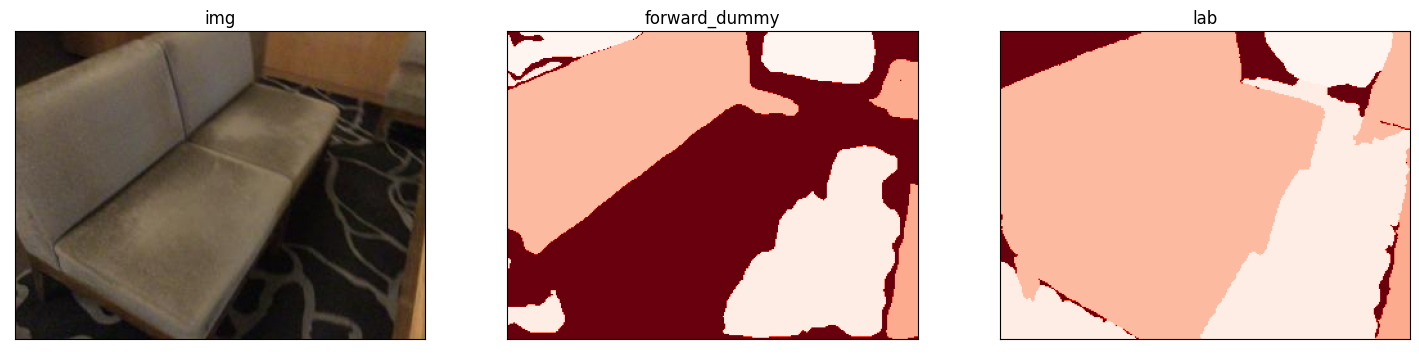

In [28]:
# result=model.forward(tensor)
#对数据进行可视化

# result_img=result.argmax(1)[0].cpu().numpy()
result = inference_model(model, cv2.imread(img_path))
myimshows([img,result.pred_sem_seg.data.cpu().numpy().squeeze(0),lab],["img","forward_dummy","lab"])

In [ ]:
import plotly.express as px
px.imshow(result.pred_sem_seg.data.cpu().numpy().squeeze(0))


In [ ]:
def mask2former_mmseg(config_file,checkpoint_file,device='cuda'):
    model = init_segmentor(config_file, checkpoint_file, device=device)
    